# Kernel light GBM Kaggle

 HOME CREDIT DEFAULT RISK COMPETITION
 Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
 Little feature selection is done and overfitting might be a problem since many features are related.
 The following key ideas were used:
 - Divide or subtract important features to get rates (like annuity and income)
 - In Bureau Data: create specific features for Active credits and Closed credits
 - In Previous Applications: create specific features for Approved and Refused applications
 - Modularity: one function for each table (except bureau_balance and application_test)
 - One-hot encoding for categorical features
 All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
 You can use LightGBM with KFold or Stratified KFold.

 Update 16/06/2018:
 - Added Payment Rate feature
 - Removed index from features
 - Use standard KFold CV (not stratified)

# Questions

1. "Get feture importances", the section in the end of the notebook. How to get the features out from the pipeline, which is the outer wrapper? Or how to get the features from ColumnTransformer (which is called Preprocessor)?

I found in internet that this job is impossible when the column transformer contains Pipelines. But the inverse isn't mentioned as impossible.
This source https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep007/proposal.html sets the problem but doesn't offer a solution. It suggests to add feature_names_in_ attribute and get_feature_names_out method to fitted estimators. But I don't see how to do that.

2. kde graph, is there a way to reduce the wiggling of the curve? Can I stay with distribution and not pass to histograms? because of the difference of the scale.

In [1]:
# conda install -c conda-forge lightgbm
# pip install imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time # in Kernel just import time
from os import listdir

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline #, make_union
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.metrics import precision_score, recall_score, make_scorer, confusion_matrix, classification_report
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score
import imblearn

rasta = 0

import gc
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
print(sklearn.__version__)#'0.24.2'
print(np.__version__) # '1.20.3'
print(pd.__version__)# '1.3.4'
print(imblearn.__version__)

1.0.2
1.20.3
1.3.4
0.9.0


In [3]:
# from os import listdir
# path_csvs = 'C:\\Users\\Veronika\\DATABASES\\p7_credit_default_risk_dataset\\'
path_csvs = 'C:\\vb\\DATABASES\\p7_credit_default_risk_dataset\\'

list_files = [file for file in listdir(path_csvs)]

print(list_files)

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [4]:
# @contextmanager
# def timer(title):
#     t0 = time()
#     yield
#     print("{} - done in {:.0f}s".format(title, time() - t0))

# # One-hot encoding for categorical columns with get_dummies
# def one_hot_encoder(df, nan_as_category = True):
#     original_columns = list(df.columns)
#     categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
#     df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
#     new_columns = [c for c in df.columns if c not in original_columns]
#     return df, new_columns

# # Preprocess application_train.csv and application_test.csv
# def application_train_test(num_rows = None, nan_as_category = False):
#     # Read data and merge
#     df = pd.read_csv(path_csvs + 'application_train.csv', nrows= num_rows)
#     test_df = pd.read_csv(path_csvs + 'application_test.csv', nrows= num_rows)
#     print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
#     df = df.append(test_df).reset_index()
#     # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
#     df = df[df['CODE_GENDER'] != 'XNA']
    
#     # Categorical features with Binary encode (0 or 1; two categories)
#     for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
#         df[bin_feature], uniques = pd.factorize(df[bin_feature])
#     # Categorical features with One-Hot encode
#     df, cat_cols = one_hot_encoder(df, nan_as_category)
    
#     # NaN values for DAYS_EMPLOYED: 365.243 -> nan
#     df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
#     # Some simple new features (percentages)
#     df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
#     df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
#     df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
#     df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
#     df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
#     del test_df
#     gc.collect()
#     return df

# # Preprocess bureau.csv and bureau_balance.csv
# def bureau_and_balance(num_rows = None, nan_as_category = True):
#     bureau = pd.read_csv(path_csvs + 'bureau.csv', nrows = num_rows)
#     bb = pd.read_csv(path_csvs + 'bureau_balance.csv', nrows = num_rows)
#     bb, bb_cat = one_hot_encoder(bb, nan_as_category)
#     bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
#     # Bureau balance: Perform aggregations and merge with bureau.csv
#     bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
#     for col in bb_cat:
#         bb_aggregations[col] = ['mean']
#     bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
#     bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
#     bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
#     bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
#     del bb, bb_agg
#     gc.collect()
    
#     # Bureau and bureau_balance numeric features
#     num_aggregations = {
#         'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
#         'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
#         'DAYS_CREDIT_UPDATE': ['mean'],
#         'CREDIT_DAY_OVERDUE': ['max', 'mean'],
#         'AMT_CREDIT_MAX_OVERDUE': ['mean'],
#         'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
#         'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
#         'AMT_CREDIT_SUM_OVERDUE': ['mean'],
#         'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
#         'AMT_ANNUITY': ['max', 'mean'],
#         'CNT_CREDIT_PROLONG': ['sum'],
#         'MONTHS_BALANCE_MIN': ['min'],
#         'MONTHS_BALANCE_MAX': ['max'],
#         'MONTHS_BALANCE_SIZE': ['mean', 'sum']
#     }
#     # Bureau and bureau_balance categorical features
#     cat_aggregations = {}
#     for cat in bureau_cat: cat_aggregations[cat] = ['mean']
#     for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
#     bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
#     bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
#     # Bureau: Active credits - using only numerical aggregations
#     active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
#     active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
#     active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
#     bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
#     del active, active_agg
#     gc.collect()
#     # Bureau: Closed credits - using only numerical aggregations
#     closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
#     closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
#     closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
#     bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
#     del closed, closed_agg, bureau
#     gc.collect()
#     return bureau_agg

# # Preprocess previous_applications.csv
# def previous_applications(num_rows = None, nan_as_category = True):
#     prev = pd.read_csv(path_csvs + 'previous_application.csv', nrows = num_rows)
#     prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
#     # Days 365.243 values -> nan
#     prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
#     prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
#     # Add feature: value ask / value received percentage
#     prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
#     # Previous applications numeric features
#     num_aggregations = {
#         'AMT_ANNUITY': ['min', 'max', 'mean'],
#         'AMT_APPLICATION': ['min', 'max', 'mean'],
#         'AMT_CREDIT': ['min', 'max', 'mean'],
#         'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
#         'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
#         'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
#         'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
#         'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
#         'DAYS_DECISION': ['min', 'max', 'mean'],
#         'CNT_PAYMENT': ['mean', 'sum'],
#     }
#     # Previous applications categorical features
#     cat_aggregations = {}
#     for cat in cat_cols:
#         cat_aggregations[cat] = ['mean']
    
#     prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
#     prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
#     # Previous Applications: Approved Applications - only numerical features
#     approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
#     approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
#     approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
#     prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
#     # Previous Applications: Refused Applications - only numerical features
#     refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
#     refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
#     refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
#     prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
#     del refused, refused_agg, approved, approved_agg, prev
#     gc.collect()
#     return prev_agg

# # Preprocess POS_CASH_balance.csv
# def pos_cash(num_rows = None, nan_as_category = True):
#     pos = pd.read_csv(path_csvs + 'POS_CASH_balance.csv', nrows = num_rows)
#     pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
#     # Features
#     aggregations = {
#         'MONTHS_BALANCE': ['max', 'mean', 'size'],
#         'SK_DPD': ['max', 'mean'],
#         'SK_DPD_DEF': ['max', 'mean']
#     }
#     for cat in cat_cols:
#         aggregations[cat] = ['mean']
    
#     pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
#     pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
#     # Count pos cash accounts
#     pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
#     del pos
#     gc.collect()
#     return pos_agg
    
# # Preprocess installments_payments.csv
# def installments_payments(num_rows = None, nan_as_category = True):
#     ins = pd.read_csv(path_csvs + 'installments_payments.csv', nrows = num_rows)
#     ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
#     # Percentage and difference paid in each installment (amount paid and installment value)
#     ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
#     ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
#     # Days past due and days before due (no negative values)
#     ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
#     ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
#     ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
#     ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
#     # Features: Perform aggregations
#     aggregations = {
#         'NUM_INSTALMENT_VERSION': ['nunique'],
#         'DPD': ['max', 'mean', 'sum'],
#         'DBD': ['max', 'mean', 'sum'],
#         'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
#         'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
#         'AMT_INSTALMENT': ['max', 'mean', 'sum'],
#         'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
#         'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
#     }
#     for cat in cat_cols:
#         aggregations[cat] = ['mean']
#     ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
#     ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
#     # Count installments accounts
#     ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
#     del ins
#     gc.collect()
#     return ins_agg

# # Preprocess credit_card_balance.csv
# def credit_card_balance(num_rows = None, nan_as_category = True):
#     cc = pd.read_csv(path_csvs + 'credit_card_balance.csv', nrows = num_rows)
#     cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
#     # General aggregations
#     cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
#     cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
#     cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
#     # Count credit card lines
#     cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
#     del cc
#     gc.collect()
#     return cc_agg

# # LightGBM GBDT with KFold or Stratified KFold
# # Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
# def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
#     # Divide in training/validation and test data
#     train_df = df[df['TARGET'].notnull()]
#     test_df = df[df['TARGET'].isnull()]
#     print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
#     del df
#     gc.collect()
#     # Cross validation model
#     if stratified:
#         folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
#     else:
#         folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
#     # Create arrays and dataframes to store results
#     oof_preds = np.zeros(train_df.shape[0])
#     sub_preds = np.zeros(test_df.shape[0])
#     feature_importance_df = pd.DataFrame()
#     feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
#     for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
#         valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

#         # LightGBM parameters found by Bayesian optimization
#         clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )

#         clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)  # here lightgbm error

#         oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
#         sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

#         fold_importance_df = pd.DataFrame()
#         fold_importance_df["feature"] = feats
#         fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["fold"] = n_fold + 1
#         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#         print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
#         del clf, train_x, train_y, valid_x, valid_y
#         gc.collect()

#     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
#     # Write submission file and plot feature importance
#     if not debug:
#         test_df['TARGET'] = sub_preds
#         test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
#     display_importances(feature_importance_df)
#     return feature_importance_df

# # Display/plot feature importance
# def display_importances(feature_importance_df_):
#     cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
#     best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
#     plt.figure(figsize=(8, 10))
#     sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
#     plt.title('LightGBM Features (avg over folds)')
#     plt.tight_layout()
#     plt.savefig('lgbm_importances01.png')


# def main(debug = False):
#     num_rows = 10000 if debug else None
#     df = application_train_test(num_rows)
#     with timer("Process bureau and bureau_balance"):
#         bureau = bureau_and_balance(num_rows)
#         print("Bureau df shape:", bureau.shape)
#         df = df.join(bureau, how='left', on='SK_ID_CURR')
#         del bureau
#         gc.collect()
#     with timer("Process previous_applications"):
#         prev = previous_applications(num_rows)
#         print("Previous applications df shape:", prev.shape)
#         df = df.join(prev, how='left', on='SK_ID_CURR')
#         del prev
#         gc.collect()
#     with timer("Process POS-CASH balance"):
#         pos = pos_cash(num_rows)
#         print("Pos-cash balance df shape:", pos.shape)
#         df = df.join(pos, how='left', on='SK_ID_CURR')
#         del pos
#         gc.collect()
#     with timer("Process installments payments"):
#         ins = installments_payments(num_rows)
#         print("Installments payments df shape:", ins.shape)
#         df = df.join(ins, how='left', on='SK_ID_CURR')
#         del ins
#         gc.collect()
#     with timer("Process credit card balance"):
#         cc = credit_card_balance(num_rows)
#         print("Credit card balance df shape:", cc.shape)
#         df = df.join(cc, how='left', on='SK_ID_CURR')
#         del cc
#         gc.collect()
#     with timer("Run LightGBM with kfold"):
#         feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

In [5]:
# if __name__ == "__main__":
#     submission_file_name = "submission_kernel02.csv"
#     with timer("Full model run"):
#         main()

Warnings:

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

Error when I launch the "main" function:

---------------------------------------------------------------------------
LightGBMError                             Traceback (most recent call last)
C:\Users\OMOREN~1\AppData\Local\Temp/ipykernel_10028/3179020771.py in <module>
      2     submission_file_name = "submission_kernel02.csv"
      3     with timer("Full model run"):
----> 4         main()

C:\Users\OMOREN~1\AppData\Local\Temp/ipykernel_10028/3345960412.py in main(debug)
    321         gc.collect()
    322     with timer("Run LightGBM with kfold"):
--> 323         feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

C:\Users\OMOREN~1\AppData\Local\Temp/ipykernel_10028/3345960412.py in kfold_lightgbm(***failed resolving arguments***)
    253             verbose=-1, )
    254 
--> 255         clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
    256             eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
    257 

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py in fit(self, X, y, sample_weight, init_score, eval_set, eval_names, eval_sample_weight, eval_class_weight, eval_init_score, eval_metric, early_stopping_rounds, verbose, feature_name, categorical_feature, callbacks, init_model)
    965                     valid_sets[i] = (valid_x, self._le.transform(valid_y))
    966 
--> 967         super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
    968                     eval_names=eval_names, eval_sample_weight=eval_sample_weight,
    969                     eval_class_weight=eval_class_weight, eval_init_score=eval_init_score,

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py in fit(self, X, y, sample_weight, init_score, group, eval_set, eval_names, eval_sample_weight, eval_class_weight, eval_init_score, eval_group, eval_metric, early_stopping_rounds, verbose, feature_name, categorical_feature, callbacks, init_model)
    746         callbacks.append(record_evaluation(evals_result))
    747 
--> 748         self._Booster = train(
    749             params=params,
    750             train_set=train_set,

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py in train(params, train_set, num_boost_round, valid_sets, valid_names, fobj, feval, init_model, feature_name, categorical_feature, early_stopping_rounds, evals_result, verbose_eval, learning_rates, keep_training_booster, callbacks)
    269     # construct booster
    270     try:
--> 271         booster = Booster(params=params, train_set=train_set)
    272         if is_valid_contain_train:
    273             booster.set_train_data_name(train_data_name)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py in __init__(self, params, train_set, model_file, model_str, silent)
   2603                 )
   2604             # construct booster object
-> 2605             train_set.construct()
   2606             # copy the parameters from train_set
   2607             params.update(train_set.get_params())

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py in construct(self)
   1813             else:
   1814                 # create train
-> 1815                 self._lazy_init(self.data, label=self.label,
   1816                                 weight=self.weight, group=self.group,
   1817                                 init_score=self.init_score, predictor=self._predictor,

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py in _lazy_init(self, data, label, reference, weight, group, init_score, predictor, silent, feature_name, categorical_feature, params)
   1571             raise TypeError(f'Wrong predictor type {type(predictor).__name__}')
   1572         # set feature names
-> 1573         return self.set_feature_name(feature_name)
   1574 
   1575     @staticmethod

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py in set_feature_name(self, feature_name)
   2140                 raise ValueError(f"Length of feature_name({len(feature_name)}) and num_feature({self.num_feature()}) don't match")
   2141             c_feature_name = [c_str(name) for name in feature_name]
-> 2142             _safe_call(_LIB.LGBM_DatasetSetFeatureNames(
   2143                 self.handle,
   2144                 c_array(ctypes.c_char_p, c_feature_name),

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py in _safe_call(ret)
    123     """
    124     if ret != 0:
--> 125         raise LightGBMError(_LIB.LGBM_GetLastError().decode('utf-8'))
    126 
    127 

LightGBMError: Do not support special JSON characters in feature name.

# The description of all the columns of all the tables

In [6]:
# HomeCredit_columns_description = pd.read_csv(path_csvs + 'HomeCredit_columns_description.csv')
# UnicodeDecodeError: 'utf-8' codec can't decode byte 0x85 in position 1283: invalid start byte

HomeCredit_columns_description = pd.read_csv(path_csvs + 'HomeCredit_columns_description.csv', encoding= 'unicode_escape')
HomeCredit_columns_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


Clients income type (businessman, working, maternity leave,)

The unreadable symbol is an ellipsis. When I replaced it with "etc.", it raised an error in a later position: 26,931 instead of 1283.

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x85 in position 26931: invalid start byte


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
     Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Number       219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB

In [7]:
# print(pd.get_option('display.max_colwidth'))
pd.set_option('max_colwidth', None)
# print(pd.get_option('display.max_colwidth'))

display(HomeCredit_columns_description.head(3))
# pd.reset_option('max_colwidth')
# print(pd.get_option('display.max_colwidth'))

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN


In [8]:
HomeCredit_columns_description.Table.unique()

array(['application_{train|test}.csv', 'bureau.csv', 'bureau_balance.csv',
       'POS_CASH_balance.csv', 'credit_card_balance.csv',
       'previous_application.csv', 'installments_payments.csv'],
      dtype=object)

In [9]:
pd.set_option('max_rows', None)
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'application_{train|test}.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT,Credit amount of the loan
9,AMT_ANNUITY,Loan annuity


In [10]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'bureau.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
122,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau"
123,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
124,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits
125,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit
126,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit
127,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample
128,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit
129,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit)
130,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)
131,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged


In [11]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'POS_CASH_balance.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
142,SK_ID_PREV,"ID of previous credit in Home Credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)"
143,SK_ID_CURR,ID of loan in our sample
144,MONTHS_BALANCE,"Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )"
145,CNT_INSTALMENT,Term of previous credit (can change over time)
146,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit
147,NAME_CONTRACT_STATUS,Contract status during the month
148,SK_DPD,DPD (days past due) during the month of previous credit
149,SK_DPD_DEF,DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit


In [12]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'credit_card_balance.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
150,SK_ID_PREV,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)"
151,SK_ID_CURR,ID of loan in our sample
152,MONTHS_BALANCE,Month of balance relative to application date (-1 means the freshest balance date)
153,AMT_BALANCE,Balance during the month of previous credit
154,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the previous credit
155,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the previous credit
156,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previous credit
157,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of the previous credit
158,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the month of the previous credit
159,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the previous credit


In [13]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'previous_application.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
173,SK_ID_PREV,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loan applications in Home Credit, previous application could, but not necessarily have to lead to credit)"
174,SK_ID_CURR,ID of loan in our sample
175,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application"
176,AMT_ANNUITY,Annuity of previous application
177,AMT_APPLICATION,For how much credit did client ask on the previous application
178,AMT_CREDIT,"Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount - AMT_CREDIT"
179,AMT_DOWN_PAYMENT,Down payment on the previous application
180,AMT_GOODS_PRICE,Goods price of good that client asked for (if applicable) on the previous application
181,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply for previous application
182,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client apply for the previous application


In [14]:
HomeCredit_columns_description.loc[HomeCredit_columns_description.Table == 'installments_payments.csv', ['Row', 'Description']]
# pd.reset_option('max_rows')

,Row,Description
211,SK_ID_PREV,"ID of previous credit in Home credit related to loan in our sample. (One loan in our sample can have 0,1,2 or more previous loans in Home Credit)"
212,SK_ID_CURR,ID of loan in our sample
213,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
214,NUM_INSTALMENT_NUMBER,On which installment we observe payment
215,DAYS_INSTALMENT,When the installment of previous credit was supposed to be paid (relative to application date of current loan)
216,DAYS_ENTRY_PAYMENT,When was the installments of previous credit paid actually (relative to application date of current loan)
217,AMT_INSTALMENT,What was the prescribed installment amount of previous credit on this installment
218,AMT_PAYMENT,What the client actually paid on previous credit on this installment


In [15]:
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Special.notna(), ['Description', 'Special']].apply(print)
# HomeCredit_columns_description.loc[HomeCredit_columns_description.Special.notna(), ['Description', 'Special']].applymap(print)
HomeCredit_columns_description.loc[HomeCredit_columns_description.Special.notna(), ['Description', 'Special']]

,Description,Special
16,Normalized population of region where client lives (higher number means the client lives in more populated region),normalized
17,Client's age in days at the time of application,time only relative to the application
18,How many days before the application the person started current employment,time only relative to the application
19,How many days before the application did client change his registration,time only relative to the application
20,How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application
33,Approximately at what hour did the client apply for the loan,rounded
41,Normalized score from external data source,normalized
42,Normalized score from external data source,normalized
43,Normalized score from external data source,normalized
44,"Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized


In [16]:
pd.reset_option("max_rows")
pd.get_option("max_rows")

60

# Aplication table

In [17]:
application_train = pd.read_csv(path_csvs + 'application_train.csv')
# application_train.info()
# application_train.iloc[:, :10].info()

In [18]:
# application_train.nunique()
# application_train.describe() # 106 columns, hard to follow
application_train.describe(include=object)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


In [19]:
application_train.describe(include=int)

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,-16036.995067,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,...,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,4363.988632,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,...,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-25229.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-19682.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-15750.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-12413.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,-7489.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In the columns Target we see, only 8% are positive target (loan fail).

In [20]:
application_train.describe(include=float)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,...,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,...,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,...,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,...,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-7479.500000,5.000000,2.000000,0.334007,3.924574e-01,...,0.000000,0.000000,0.000000,-1570.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-4504.000000,9.000000,2.000000,0.505998,5.659614e-01,...,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-2010.000000,15.000000,3.000000,0.675053,6.636171e-01,...,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,0.000000,91.000000,20.000000,0.962693,8.549997e-01,...,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


## Impute missing values

### Categorical variables
### Strategy
#### Cautious strategy
The strategy is not the same for filling the train set and the test set:
- For the test set, if we don't know the value, we shall use the most "risky" variant: the value that gives the highest rate of positive target.
- For the train set, we know the traget. So, if the target is negative, no need to set the parameter to the "most risky" category. I will assign it to the a category (more on that later), if the number of missing values is below the limit (let's say arbitrarily, 5%) and to a standalone "unknown" category, if the number of missing values is above this limit.
- How to choose a category: we already know the target value. So, for the positive target we give the "most risky" value to the unknown. For the negative target, we give the most frequent value, doesn't matter what's the risk (can be the most risky, the least, or somewhere in the middle, we just take the most frequent).
- The drawback of such a distiction on the category: we risk to overfit our model. But, we will overfit it in a lopsided way: the model will tend to give more importance on the imputed features to lead to positive target. But this drawback plays on our side at the end of the game: as on test set we impute the "most risky" value every time, the model will give more false negatives, but will be much less likely to let pass the false positives. That means, we can explain the refuse to a client based on the features that were not provided by the client, so the client knows what cells (s)he has to modify or fill.
- How we detect "the most risky" category: by groupby-aggregation test. Look the correlation between positive target (credit fail) and different values. See the proportion of people who failed to pay their credit for every value. The value with the highest proportion of positive target is "the most risky" one.
- How to store "the most risky" values: maybe as a dictionary. The key is the feature that we want to impute, the value is the most risky category.
#### When to apply cautious strategy
When we suppose that a false positive is significantly more costly to the bank than a false negative is. If it happens that the difference between the cost of false negative and false positive is insignificant for the bank, we can pass to simplified strategy.
#### Simplified strategy
Impute with "the most risky" value for test set and with the most frequent value for the train set.
#### Simplest strategy
Impute with the most frequent value for both train and test sets.
#### How to handle the values which are already imputed as "unknown", "not specified", "XNA" or similar
When you look through unique values, you might notice that some categorical values are filled with "unknown", "not_specified", "XNA" or similar kinds of values. All that means "NaN", basically.
The best of all would be to ask a confirmation on the business side, whether it's indeed smth like "this info is lacking", which equelas NaN.

If it is so, the best is to delete these values/replace by "NaN", and then apply the standard algorithm, described before.

Example: GENDER_CODE. Among 307511 applications, 4 applicants have "XNA" value. It's like "nan", just it's filled with text. So I will replace "XNA" with "nan", and then treat it along the general algorithm:
    it's less than 5% NaNs, so impute 
    -with most risky for test set, 
    -with  most risky for train set positive target, 
    - with most frequent for train set negtive target.
The most risky value from groupby-aggreagtion test is "M".

In [21]:
selectcol = application_train.select_dtypes(include='object')
selectcol.info()
display(selectcol.nunique())

selectcol_fill_targ = selectcol.fillna('unknown')
selectcol_fill_targ['SK_ID_CURR'] = application_train['SK_ID_CURR']
selectcol_fill_targ['TARGET'] = application_train['TARGET']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   NAME_CONTRACT_TYPE          307511 non-null  object
 1   CODE_GENDER                 307511 non-null  object
 2   FLAG_OWN_CAR                307511 non-null  object
 3   FLAG_OWN_REALTY             307511 non-null  object
 4   NAME_TYPE_SUITE             306219 non-null  object
 5   NAME_INCOME_TYPE            307511 non-null  object
 6   NAME_EDUCATION_TYPE         307511 non-null  object
 7   NAME_FAMILY_STATUS          307511 non-null  object
 8   NAME_HOUSING_TYPE           307511 non-null  object
 9   OCCUPATION_TYPE             211120 non-null  object
 10  WEEKDAY_APPR_PROCESS_START  307511 non-null  object
 11  ORGANIZATION_TYPE           307511 non-null  object
 12  FONDKAPREMONT_MODE          97216 non-null   object
 13  HOUSETYPE_MODE              1

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [22]:
def find_most_risky(mycol, my_df=selectcol_fill_targ, show=True):
    if show:
        print(my_df[mycol].value_counts())

    # test = application_train.groupby(['TARGET', 'CODE_GENDER']).agg('count').iloc[:, 0].unstack().fillna(0)
    test = my_df.groupby(['TARGET', mycol])['SK_ID_CURR'].agg('count').unstack().fillna(0)
    # sns.heatmap(test, annot=True, cmap='Blues', fmt='g')
    test_t = test.transpose()

    test1 = pd.DataFrame() # which proportion of every value has failed the credit 
    for col in test: # how high chances are that a given person with a given value will fail the credit
        test1[col] = test[col] / test[col].sum() * 100
        test2 = test1.transpose().sort_values(1, ascending=False)
    if show:
        display(test2)
    
#     # this table we dont' need to define the most risky category
#         test2 = pd.DataFrame() # who failed the credit: among failers, what are the proportion of each value
#     for col in test_t:
#         test2[col] = test_t[col] / test_t[col].sum() * 100
#     display(test2) # given that the person has failed the credit, how high are the chances that (s)he is in each category
    if show:
        return None
    else:
        return test2#.reset_index()

In [23]:
# how many NaNs, percentage
for col in selectcol:
    print(col, application_train[col].isna().sum() / application_train.shape[0] * 100)

NAME_CONTRACT_TYPE 0.0
CODE_GENDER 0.0
FLAG_OWN_CAR 0.0
FLAG_OWN_REALTY 0.0
NAME_TYPE_SUITE 0.42014757195677555
NAME_INCOME_TYPE 0.0
NAME_EDUCATION_TYPE 0.0
NAME_FAMILY_STATUS 0.0
NAME_HOUSING_TYPE 0.0
OCCUPATION_TYPE 31.345545362604916
WEEKDAY_APPR_PROCESS_START 0.0
ORGANIZATION_TYPE 0.0
FONDKAPREMONT_MODE 68.38617155158677
HOUSETYPE_MODE 50.176091261776
WALLSMATERIAL_MODE 50.8407829313423
EMERGENCYSTATE_MODE 47.39830445089769


For every categorical column, I calculate how many percents of loaners are failed their loan for every available value. That allows to estimate is there's a difference, and approximately estiate how storng this difference is. In other words, how strong is the impact of this feature on target.

This approach looks at each variable like if it was independent from other variables. It doesn't take into account the interactions between variables. Like, that that the a1&b1 is good, a2&b2 is good, but a2&b1 is bad, a1b2 is bad. Like a saddle point.

In [24]:
# find_most_risky('NAME_CONTRACT_TYPE') # cash 8.3, revolving 5.4
# find_most_risky('CODE_GENDER') # F 7.0, M 10.1, XNA equals NaN 0 (0 out of 4 people)
# find_most_risky('FLAG_OWN_CAR') # No 8.5, Yes 7.2
# find_most_risky('FLAG_OWN_REALTY') # No 8.32 Yes 7.96
# find_most_risky('NAME_TYPE_SUITE') # NaN 5.4(min), Other_B 9.8 (max value)
# find_most_risky('NAME_INCOME_TYPE') # Businessman 0(min value), maternity leave 40 (max value), unemployed 36.4
# find_most_risky('NAME_EDUCATION_TYPE') # correlation: monotonic, but not proportional! academic 1.8, lower secondary 10.9
# find_most_risky('NAME_FAMILY_STATUS') # widow 5.8(min), civil marriage 9.9(max), single 9.8, unknown = NaN 0 (0 out of 2)
# find_most_risky('NAME_HOUSING_TYPE') # office appartment 6.5(min), rented apartment 12.3 (max value), with parents 11.7
find_most_risky('OCCUPATION_TYPE') # 19 DIMENSIONS accountants 4.8(min), low-skill Laborers 17.1 (max value)
# find_most_risky('WEEKDAY_APPR_PROCESS_START') # Mon7.75(min), Sat7.78, Sun7.92, Tue8.35(max). Remove this feature.
# find_most_risky('ORGANIZATION_TYPE') # 58 DIMENSIONS tradeType4 3.12(min), transportType3 15.75(max) 58 columns!
# find_most_risky('FONDKAPREMONT_MODE') # orgSpecAcc 5.8 (min), unknown 8.6 (max), "not specified" means NaN 7.5
# find_most_risky('HOUSETYPE_MODE') # blockOfFLats 6.9, specificHousing 10.1(max), NaN 9.15
# find_most_risky('WALLSMATERIAL_MODE') # Monolithic 4.72(min), wooden 9.69, unknown 9.12
# find_most_risky('EMERGENCYSTATE_MODE') # No 7.0, Yes 9.57, NaN 9.26

unknown                  96391
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64


TARGET,0,1
Low-skill Laborers,82.847587,17.152413
Drivers,88.673870,11.326130
Waiters/barmen staff,88.724036,11.275964
Security staff,89.257551,10.742449
Laborers,89.421230,10.578770
Cooking staff,89.556004,10.443996
Sales staff,90.368201,9.631799
Cleaning staff,90.393295,9.606705
Realty agents,92.143808,7.856192
Secretaries,92.950192,7.049808


## Function for replacement of categorical variable to the proportion of failers

The purpose is to reduce dimensions. The potential drawback is that the train test split will be not homogenous, which will create the biased probabilities/weights of fail. But it worth trying, because it allows to reduce the dimension of occupation from 19 to 1 and from organization from 58 to 1.

In [25]:
df_test = selectcol_fill_targ.copy()
print(df_test.shape)
df_test.columns

(307511, 18)


Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
       'SK_ID_CURR', 'TARGET'],
      dtype='object')

In [26]:
def category_to_fail_proportion(my_df, my_series): # should be a string
    probas_table = find_most_risky(my_series, my_df=my_df, show=False)
#     for item in probas_table['index']: # if we reset index in the function "find_most_risky"
#     for item in probas_table.index:
#         # changes variables in the outer space (global or not)
#         # my_df[my_df[my_series] == item] = probas_table.loc[item, 1] # works, but slowly
#         # also change variables in the outer space (global or not). only if we add inplace=True
#         # without inplace=True, doesn't replace variables even in local space
#         my_df[my_series].replace(item, probas_table.loc[item, 1], inplace=True) # works, but slowly
# #     is it possible to use "apply", "applymap" or "transfrom" ?
    # apply creates a copy of Series, doesn't touch the objects in the outer space
    proba_series = my_df[my_series].apply(lambda x: probas_table.loc[x, 1]) # works faster the "for" cycle with item and lines selection for every item
#     return my_df[my_series] #unnecessary, because the function has modified the objects in the outer space anyway
    return proba_series

In [27]:
category_to_fail_proportion(df_test, 'OCCUPATION_TYPE')

0         10.578770
1          6.303954
2         10.578770
3         10.578770
4          6.303954
            ...    
307506     9.631799
307507     6.513056
307508     6.214028
307509    10.578770
307510    10.578770
Name: OCCUPATION_TYPE, Length: 307511, dtype: float64

In [28]:
# df_test.OCCUPATION_TYPE
# df_test.info()

In [29]:
df_test['OCCUPATION_TYPE'] = category_to_fail_proportion(df_test, 'OCCUPATION_TYPE')
# df_test.info() # the type has changed from object to float

In [30]:
df_test['ORGANIZATION_TYPE'] = category_to_fail_proportion(df_test, 'ORGANIZATION_TYPE')

In [31]:
df_test['ORGANIZATION_TYPE'] = category_to_fail_proportion(df_test, 'ORGANIZATION_TYPE')

In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   NAME_CONTRACT_TYPE          307511 non-null  object 
 1   CODE_GENDER                 307511 non-null  object 
 2   FLAG_OWN_CAR                307511 non-null  object 
 3   FLAG_OWN_REALTY             307511 non-null  object 
 4   NAME_TYPE_SUITE             307511 non-null  object 
 5   NAME_INCOME_TYPE            307511 non-null  object 
 6   NAME_EDUCATION_TYPE         307511 non-null  object 
 7   NAME_FAMILY_STATUS          307511 non-null  object 
 8   NAME_HOUSING_TYPE           307511 non-null  object 
 9   OCCUPATION_TYPE             307511 non-null  float64
 10  WEEKDAY_APPR_PROCESS_START  307511 non-null  object 
 11  ORGANIZATION_TYPE           307511 non-null  float64
 12  FONDKAPREMONT_MODE          307511 non-null  object 
 13  HOUSETYPE_MODE

### What we see for missing categorical values

CODE_GENDER: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 0 to 7.0. With cautious strategy - rise even higher, from 0 to 10.1. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.001%, we can't take them into a separated category_

NAME_TYPE_SUITE: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 5.4 to 8.2. With cautious strategy - rise even higher, from 5.4 to 9.8. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.42%, we can't take them into a separated category_

NAME_FAMILY_STATUS: Unknown is the least failed category. With the simplest strategy we tend to rise the failure impact from 0 to 7.56. With cautious strategy - rise even higher, from 0 to 9.94. __Simplest__ strategy is closer to reality.
_the proportion of NaNs is low, 0.001%, we can't take them into a separated category_

OCCUPATION_TYPE: With the simplest strategy we tend to rise the failure impact from 6.5 to 10.5 (most frequent group is Laborers). With cautious strategy - rise even higher, from 6.5 to 17.1. __Simplest__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart, and this is better than both simplest or cautious_

FONDCAPREMONT: With the simplest strategy we tend to bring down the failure impact from 8.6 to 7.0 (most frequent group is reg oper account). With cautious strategy - bring down less, from 8.6 to 7.5. __Cautious__ strategy is closer to reality.
Here, as we have the category "not specified", we can combine them. That would be equal to cautious strategy.
Or, _as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension, so let's just replace "not specified" with NaN and combine with NaNs into a separate category._

HOUSETYPE_MODE: With the simplest strategy we tend to bring down the failure impact from 9.15 to 7.0 (most frequent group is block of flats). With cautious strategy - to rise the failure from 9.15 to 10.1. __Cautious__ strategy is closer to reality.
Here, as we have the category "not specified", we can combine them. That would be equal to cautious strategy.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

WALLSMATERIAL_MODE: With the simplest strategy we tend to bring down the failure impact from 9.1 to 6.3 (most frequent group is panel). With cautious strategy - to rise the failure from 9.1 to 9.7. __Cautious__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

EMERGENCYSTATE_MODE: With the simplest strategy we tend to bring down the failure impact from 9.3 to 7.0 (most frequent group is No). With cautious strategy - to rise the failure from 9.3 to 9.6. __Cautious__ strategy is closer to reality.
_as the proportion of NaNs is higher than 5%, we can take them apart. This solution will bring en extra dimension._

At this step, I will replace all the missing values with simplest strategy, but I will choose the string to fill by different strategies: simplest where it's closer to reality, cautious where it's closer to reality.

In [33]:
# selectcol.NAME_TYPE_SUITE.value_counts()
# selectcol.OCCUPATION_TYPE.value_counts()
# selectcol.FONDKAPREMONT_MODE.value_counts()
# selectcol.HOUSETYPE_MODE.value_counts()
# selectcol.WALLSMATERIAL_MODE.value_counts()
selectcol.EMERGENCYSTATE_MODE.value_counts()

No     159428
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64

In [34]:
application_train.loc[application_train.CODE_GENDER == 'XNA', 'CODE_GENDER'] = 'F' # as most frequent
application_train.loc[application_train.NAME_FAMILY_STATUS == 'Unknown', 'NAME_FAMILY_STATUS'] = 'Married' # as most frequent
application_train.loc[application_train.FONDKAPREMONT_MODE == 'not specified', 'FONDKAPREMONT_MODE'] = 'unknown' # "not specified" in fact means NaN


application_train['NAME_TYPE_SUITE'] = application_train.NAME_TYPE_SUITE.fillna('Unaccompanied') # as most frequent
application_train['OCCUPATION_TYPE'] = application_train.OCCUPATION_TYPE.fillna('unknown') # new category
application_train['FONDKAPREMONT_MODE'] = application_train.FONDKAPREMONT_MODE.fillna('unknown') # merge with "not specified"
application_train['HOUSETYPE_MODE'] = application_train.HOUSETYPE_MODE.fillna('unknown') # as most frequent
application_train['WALLSMATERIAL_MODE'] = application_train.WALLSMATERIAL_MODE.fillna('unknown') # as most frequent
application_train['EMERGENCYSTATE_MODE'] = application_train.EMERGENCYSTATE_MODE.fillna('Yes') # as most risky


In [35]:
# application_train.NAME_TYPE_SUITE.value_counts()
# application_train.OCCUPATION_TYPE.value_counts()
# application_train.FONDKAPREMONT_MODE.value_counts()
# application_train.HOUSETYPE_MODE.value_counts()
# application_train.WALLSMATERIAL_MODE.value_counts()
application_train.EMERGENCYSTATE_MODE.value_counts()

No     159428
Yes    148083
Name: EMERGENCYSTATE_MODE, dtype: int64

#### Flags look at the most risky category
#### See whether there's a correlation between integers and target

In [36]:
selectcol = application_train.select_dtypes(include='int')

selectcol_fill_targ = selectcol.fillna('unknown')
selectcol_fill_targ['SK_ID_CURR'] = application_train['SK_ID_CURR']
selectcol_fill_targ['TARGET'] = application_train['TARGET']

In [37]:
selectcol_fill_targ.columns

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],
      dtype='object')

In [38]:
# WARNING: if I don't put the same function second time, the notbook rises an error!

def find_most_risky(mycol, my_df=selectcol_fill_targ, show=True):
    if show:
        print(my_df[mycol].value_counts())

    # test = application_train.groupby(['TARGET', 'CODE_GENDER']).agg('count').iloc[:, 0].unstack().fillna(0)
    test = my_df.groupby(['TARGET', mycol])['SK_ID_CURR'].agg('count').unstack().fillna(0)
    # sns.heatmap(test, annot=True, cmap='Blues', fmt='g')
    test_t = test.transpose()

    test1 = pd.DataFrame() # which proportion of every value has failed the credit 
    for col in test: # how high chances are that a given person with a given value will fail the credit
        test1[col] = test[col] / test[col].sum() * 100
        test2 = test1.transpose().sort_values(1, ascending=False)
    if show:
        display(test2)
    
#     # this table we dont' need to define the most risky category
#         test2 = pd.DataFrame() # who failed the credit: among failers, what are the proportion of each value
#     for col in test_t:
#         test2[col] = test_t[col] / test_t[col].sum() * 100
#     display(test2) # given that the person has failed the credit, how high are the chances that (s)he is in each category
    if show:
        return None
    else:
        return test2#.reset_index()

In [39]:
# find_most_risky('CNT_CHILDREN') # correlation, but not linear. on rare values the curve starts jumping

# find_most_risky('FLAG_MOBIL') # 1 person without mobile, target 0. DROP THIS FEATURE
# find_most_risky('FLAG_EMP_PHONE') # 8.6 vs 5.4 (55,000 people)
# find_most_risky('FLAG_WORK_PHONE') # 9.6 vs 7.7(61,000 people) drop? no

# find_most_risky('FLAG_CONT_MOBILE') # 8.1 vs 7.8(574 people) DROP THIS FEATURE
# find_most_risky('FLAG_PHONE') # 8.5 vs 7.0 (86,000 people)

# find_most_risky('FLAG_EMAIL') #  8.1 vs 7.9 (17400 people) DROP THIS FEATURE
find_most_risky('REGION_RATING_CLIENT') # 11%, 7% and 4% fail. absolutely need to include.

find_most_risky('REGION_RATING_CLIENT_W_CITY') # 11%, 7% and 4% fail. check whether correlates with REGION_RATING_CLIENT
# find_most_risky('HOUR_APPR_PROCESS_START') # kinda peak at 22,23,24=0. shall I replace 0 with 24? next peak is 5,6,7 am, but surprisingly not 1,2,3,4 am
# find_most_risky('REG_REGION_NOT_LIVE_REGION') # 8.1 vs 9.3 (4500 people) drop? no
# find_most_risky('REG_REGION_NOT_WORK_REGION') # 8.1 vs 8.9 (15,000 people) drop? no
# find_most_risky('LIVE_REGION_NOT_WORK_REGION') # 8.1 vs 8.4 (12,000 people) drop? no
# find_most_risky('REG_CITY_NOT_LIVE_CITY') # 7.7 vs 12.2 (24,000 people) high correlation: important feature!
# find_most_risky('REG_CITY_NOT_WORK_CITY') # 7.3 vs 10.6 (70,000 people)
# find_most_risky('LIVE_CITY_NOT_WORK_CITY') # 7.6 vs 10.0 (55,people)
# find_most_risky('FLAG_DOCUMENT_2') # 30% fail with 1 (of 30 people), 8% fail with no 
# find_most_risky('FLAG_DOCUMENT_3') # 8.8 vs 6.1 to fail. drop? no
# find_most_risky('FLAG_DOCUMENT_4') # 25 people have flag, target 0 of 25. it's like doc2 but inverse
# find_most_risky('FLAG_DOCUMENT_5') # 8.07 vs 8.0. DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_6') # 8.3 vs 5.56 to fail
# find_most_risky('FLAG_DOCUMENT_7') # 8.1 vs 5.1 to fail, 57 people have it. drop? no
# find_most_risky('FLAG_DOCUMENT_8') # 8.1 vs 7.3 to fail. 25,000 people have it. drop? no
# find_most_risky('FLAG_DOCUMENT_9') # 8.1 vs 6.1 to fail.  1200 people have it. drop? no

# find_most_risky('FLAG_DOCUMENT_10') # 7 people have flag, target 0 of 7. DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_11') # 8.1 vs 6.2 to fail, 1203 pepole have it. drop? no
# find_most_risky('FLAG_DOCUMENT_12')  # 2 people have flag, target 0 of 2. drop? no. but only 2 people
# find_most_risky('FLAG_DOCUMENT_13') # 8.1 (all) vs 2.7 (1200 people)
# find_most_risky('FLAG_DOCUMENT_14') # 8.1 vs 3.3 (903 people)
# find_most_risky('FLAG_DOCUMENT_15') # 8.1 vs 3.0 (372 people)
# find_most_risky('FLAG_DOCUMENT_16') # 8.1 vs 4.9 (3,000 people)
# find_most_risky('FLAG_DOCUMENT_17') # 8.1 vs 2.4 (82 people). drop? no. but there are few people
# find_most_risky('FLAG_DOCUMENT_18') # 8.1 vs 5.7 (2500 people)
# find_most_risky('FLAG_DOCUMENT_19') # 8.1 vs 6.55 (183 people). drop? no. but there are few people

# find_most_risky('FLAG_DOCUMENT_20') # 8.1 vs 8.3(156 people). DROP THIS FEATURE
# find_most_risky('FLAG_DOCUMENT_21') # 8.1 vs 13.6 (103 people)


2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64


TARGET,0,1
3,88.897165,11.102835
2,92.110898,7.889102
1,95.179675,4.820325


2    229484
3     43860
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64


TARGET,0,1
3,88.597811,11.402189
2,92.082237,7.917763
1,95.159072,4.840928


In [40]:
application_train.loc[application_train.HOUR_APPR_PROCESS_START == 0, 'HOUR_APPR_PROCESS_START'] = 24

In [41]:
confusion_matrix(selectcol.REGION_RATING_CLIENT, selectcol.REGION_RATING_CLIENT_W_CITY)

array([[ 32197,      0,      0],
       [  1248, 225736,      0],
       [   722,   3748,  43860]], dtype=int64)

Highly correlated values. Let's just double-check that in the applications where REGION_RATING_CLIENT is higher than REGION_RATING_CLIENT_W_CITY, the proportion of credit fail is higher.

In [42]:
test_df = selectcol[selectcol.REGION_RATING_CLIENT > selectcol.REGION_RATING_CLIENT_W_CITY]

# find_most_risky('REGION_RATING_CLIENT', my_df=test_df)
# find_most_risky('REGION_RATING_CLIENT_W_CITY', my_df=test_df)

test = test_df.groupby(['TARGET', 
                 'REGION_RATING_CLIENT', 
                 'REGION_RATING_CLIENT_W_CITY'])['SK_ID_CURR'].agg('count').unstack().unstack().fillna(0)
test_t = test.transpose()
display(test_t)

test1 = pd.DataFrame() # which proportion of every value has failed the credit 
for col in test: # how high chances are that a given person with a given value will fail the credit
    test1[col] = test[col] / test[col].sum() * 100
    test2 = test1.transpose().sort_values(1, ascending=False)
display(test2)


TARGET                                                 0      1
REGION_RATING_CLIENT_W_CITY REGION_RATING_CLIENT               
1                           2                     1189.0   59.0
                            3                      679.0   43.0
2                           2                        0.0    0.0
                            3                     3426.0  322.0

TARGET,0,1
"(2, 3)",91.408751,8.591249
"(1, 3)",94.044321,5.955679
"(1, 2)",95.272436,4.727564
"(2, 2)",NaN,NaN


In [43]:
test = test_df.groupby(['TARGET', 
                 'REGION_RATING_CLIENT', 
                 'REGION_RATING_CLIENT_W_CITY'])['SK_ID_CURR'].agg('count').unstack().unstack().fillna(0)
test_t = test.transpose()
display(test_t)

test1 = pd.DataFrame() # which proportion of every value has failed the credit 
for col in test: # how high chances are that a given person with a given value will fail the credit
    test1[col] = test[col] / test[col].sum() * 100
    test2 = test1.transpose().sort_values(1, ascending=False)
display(test2)


TARGET                                                 0      1
REGION_RATING_CLIENT_W_CITY REGION_RATING_CLIENT               
1                           2                     1189.0   59.0
                            3                      679.0   43.0
2                           2                        0.0    0.0
                            3                     3426.0  322.0

TARGET,0,1
"(2, 3)",91.408751,8.591249
"(1, 3)",94.044321,5.955679
"(1, 2)",95.272436,4.727564
"(2, 2)",NaN,NaN


#### Numeric variables treatment

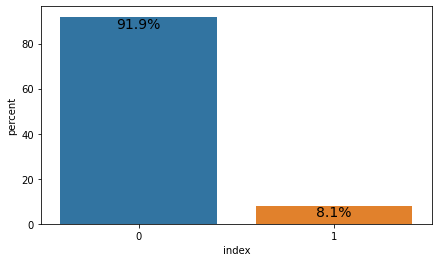

In [44]:
norm_target = application_train.TARGET.value_counts(normalize=True).mul(100).rename('percent').reset_index()

plt.figure(figsize=(7,4))
# ax = sns.barplot(x=norm_target.index, y=norm_target.values, data=norm_target)
ax = sns.barplot(x='index', y='percent', data=norm_target)

# annotate shows the values above the graphs
# in the cycle, take every bar on the graph and write the value
for patch in ax.patches:
    percentage= '{:.1f}%'.format(patch.get_height())
    ax.annotate(percentage, # text
    (patch.get_x() + patch.get_width() / 2, patch.get_height()), # set x and y for the annotation
    ha='center',
    va='top',
#     xytext=(0, 10), # with this line all the annotations are located in the same area, signatures overlap
#     textcoords='offset_points', # shift from the coordinate
    fontsize=14)

In [45]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path_csvs + 'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(path_csvs + 'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

<AxesSubplot:>

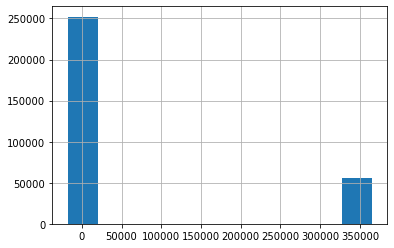

In [46]:
application_train.DAYS_EMPLOYED.hist() # a peak around 350,000

In [47]:
application_train.loc[application_train.DAYS_EMPLOYED > 3_000, 'DAYS_EMPLOYED'].value_counts() #365243 is 1,000 years

365243    55374
Name: DAYS_EMPLOYED, dtype: int64

In [48]:
application_train.loc[application_train.DAYS_EMPLOYED > 10_000, 'DAYS_EMPLOYED'] = np.nan 
# application_train.replace(365243, np.nan, inplace=True) # works as well

<AxesSubplot:>

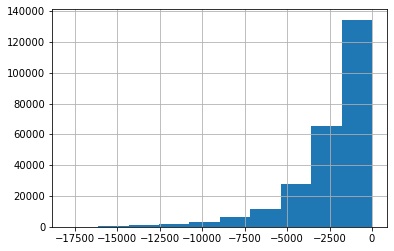

In [49]:
application_train.DAYS_EMPLOYED.hist() # How many days before the application the person started current employment

<AxesSubplot:>

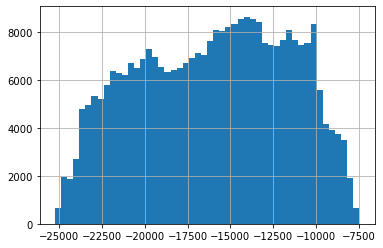

In [50]:
application_train.DAYS_BIRTH.hist(bins=50) # Client's age in days at the time of application

In [51]:
#age in years
print(application_train.DAYS_BIRTH.min() / 365.25)
print(application_train.DAYS_BIRTH.max() / 365.25)
# age in years is correct, but is given in negative numbers

-69.07323750855578
-20.503764544832308


In [52]:
#last/current job duration in years
print(application_train.DAYS_EMPLOYED.min() / 365.25)
print(application_train.DAYS_EMPLOYED.max() / 365.25)
# job duration in years is correct, but is given in negative numbers

-49.040383299110196
0.0


Will it not be easier if I just multiply the age of the client and the job duration to -1 ? Maybe it will break the interactions with other variables, which relate on the fact that these two variables are negative? For the moment I will not multiply them by -1, I will only take an account of it in the exploratory phase

In [53]:
# application_train[application_train.DAYS_EMPLOYED < application_train.DAYS_BIRTH] # correct: empty, as should be

# minimal age when a client started the last/current job
print((min(application_train.DAYS_EMPLOYED - application_train.DAYS_BIRTH)) / 365.25)
# maximal age when a client started the last/current job
print((max(application_train.DAYS_EMPLOYED - application_train.DAYS_BIRTH)) / 365.25)

17.916495550992472
68.16427104722793


<AxesSubplot:>

<AxesSubplot:>

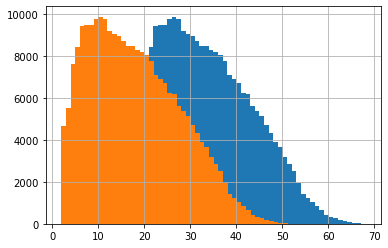

In [54]:
# to start the count from 16 years (or 5844 days), the minimal age when a person is allowed to work
display(((application_train.DAYS_EMPLOYED - application_train.DAYS_BIRTH) / 365.25).hist(bins=50))
display(((application_train.DAYS_EMPLOYED - application_train.DAYS_BIRTH - 5844) / 365.25).hist(bins=50))
# apparently no need to to such a substraction. It will be done automatically at StandardScaler step

<AxesSubplot:>

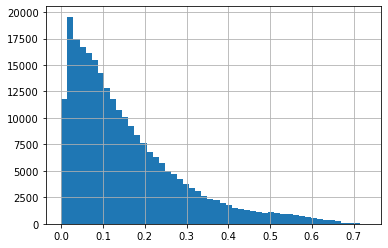

In [55]:
(application_train['DAYS_EMPLOYED'] / application_train['DAYS_BIRTH']).hist(bins=50)

## Other tables than "application train"

In [56]:
# bureau = pd.read_csv(path_csvs + 'bureau.csv')
# bureau.info()

In [57]:
# bureau_balance = pd.read_csv(path_csvs + 'bureau_balance.csv')
# bureau_balance.info()

In [58]:
# credit_card_balance = pd.read_csv(path_csvs + 'credit_card_balance.csv')
# credit_card_balance.info()

In [59]:
# installments_payments = pd.read_csv(path_csvs + 'installments_payments.csv')
# installments_payments.info()

In [60]:
# POS_CASH_balance = pd.read_csv(path_csvs + 'POS_CASH_balance.csv')
# POS_CASH_balance.info()

In [61]:
# previous_application = pd.read_csv(path_csvs + 'previous_application.csv')
# previous_application.info()

In [62]:
# previous_application.select_dtypes(include='object').info()

In [63]:
# sample_submission = pd.read_csv(path_csvs + 'sample_submission.csv')
# sample_submission.info()

In [64]:
pd.reset_option("max_rows")
pd.get_option("max_rows")

60

# Data cleaning

The simplest cleaning consist of remove all the columns that have NaN values, then keeping only the columns that have 2 or 3 unique values. If we have more than 10 dimensions, we can test it as a dummy model.

In [65]:
data_cleaned = application_train.dropna(axis=1).copy()
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 60 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   NAME_TYPE_SUITE              307511 non-null  object 
 10  NAME_INCOME_TYPE             307511 non-null  object 
 11  NAME_EDUCATION_TYPE          307511 non-null  object 
 12  NAME_FAMILY_STATUS           307511 non-null  object 
 13 

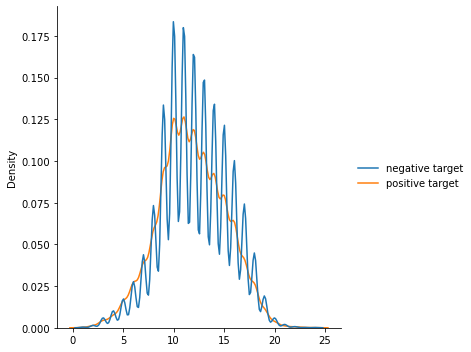

In [66]:
sns.displot({'negative target': application_train[application_train.TARGET == 0].HOUR_APPR_PROCESS_START,
    'positive target': application_train[application_train.TARGET == 1].HOUR_APPR_PROCESS_START},
    kind='kde', common_norm=False) #independent normalization for each subset

# there are 50 bins by default, no?

according to histogram it makes sense to include HOUR_APPR_PROCESS_START column in the account. But the correlation isn't linear.

In [67]:
# data_cleaned = data_cleaned.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1)
data_cleaned = data_cleaned.drop(['WEEKDAY_APPR_PROCESS_START'], axis=1)

# Train test split

Stratified train test split which preserves the proportion of negative and positive as in whe whole dataset (8% positives in both train split and test split)

In [104]:
data_train, data_test = train_test_split(data_cleaned, test_size=0.2, random_state = rasta, stratify=data_cleaned.TARGET)

In [105]:
X_train = data_train.drop('TARGET', axis=1)
X_test = data_test.drop('TARGET', axis=1)
y_train = data_train.TARGET.values
y_test = data_test.TARGET.values
X_full = data_cleaned.drop('TARGET', axis=1)

In [106]:
print(f'X train: {X_train.shape}, X test: {X_test.shape}, y train: {y_train.shape}, y train: {y_test.shape}, ')

X train: (246008, 58), X test: (61503, 58), y train: (246008,), y train: (61503,), 


In [107]:
print(len(y_test), "test values")
print(y_test.sum(), "positive values in test set")

61503 test values
4965 positive values in test set


# Dummy classifier

We work with a database which has a major and a minor class, where the detection of the minor class is super-important. Let's call the minor class (fail to pay the credit) positive, and major class (manages to pay the credit) negative.
Then the dummy classifier will always predict the negative class.

The DummyClassifier Method in Scikit Learn uses "prior" strategy. The "predict" method always returns the most frequent class label in the observed y argument passed to fit (like "most_frequent). 

The "predict_proba" always returns the empirical class distribution of y also known as the empirical class prior distribution. In our case it means it will return the probabiliteis proportionally to what it have seen at fitting stage: 92% negative, 8% positive.

Meanwhile the "predict_proba" with "most_frequent" strategy returns the matching one-hot encoded vector, which means vector composed of 0s in our case or of 1s.

In [72]:
dummy_clf = DummyClassifier(strategy='prior')
dummy_clf.fit(X_train, y_train)
# dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.9192722306228964

# Metrics for model evaluation

As we see, the dummy classifier has 92% accuracy.

The metric that interests us, is how much of positives are correctly detected. How much of the positives are true positives. How much of negatives are false negatives. The objective is to have as few false negatives as possible.

Precision allows not to mark a reliable client as a suspicious one. HIgher the precision, better this probability is. 
It shows how many clients are really failsome, out of predicted as such.

Recall allows not to mark a suspicious client as a reliable one. This metric is essential, the priority should be given to it. It shows how many positives were picked up and not missed, out of all existing failsome clients.

From the other hand, an algoritm that marks everyone as suspicious, would have 100% of recall, but have bad other metrics, and would be a useless model. So the balance should be found between the recall and other metrics (like precision or maybe others).

The balance can be found with 1F score.

In [73]:
errors = []

In [108]:
def compare_model(my_estimator, model_name, my_params={}, smote=False, perso=False):
# def compare_model(my_estimator, model_name, my_params={}, perso=False):
    
#     if smote:
#         oversample = SMOTE()
#         X_train, y_train = oversample.fit_resample(X_train, y_train)
    
    if not perso:
        scoring = ['roc_auc', 'recall', 'precision']
        refit='roc_auc'
#         refit=False # AttributeError: 'GridSearchCV' object has no attribute 'best_params_'. For multi-metric evaluation, this is present only if refit is specified
    else:
        scoring = my_scoring # my_scorer, also works, if you uncomment the line. my_scoring['perso'] also works
#         refit='perso'
        refit='roc_auc' # temporary for debugging, to show that the problem isn't in the metric or scorer
#         refit=my_scoring['perso'] #TypeError: __call__() missing 2 required positional arguments: 'X' and 'y_true'

    if not smote:
        model = make_pipeline(preprocessor, 
                GridSearchCV(
                          estimator=my_estimator, 
                          param_grid=my_params, 
                          cv=2, 
                          scoring=scoring, 
#                           scoring='roc_auc', 
                          return_train_score = True, 
                          refit=refit, #'roc_auc', 
                          n_jobs = -1
                      ))

    
    else:
        model = GridSearchCV(
                          estimator=my_estimator, 
                          param_grid=my_params, 
                          cv=2, 
                          scoring=scoring, 
#                           scoring='roc_auc', 
                          return_train_score = True, 
                          refit=refit, #'roc_auc', 
                          n_jobs = -1
                      )
    
    time1 = time()
    print('Fitting started')
#     model.fit(X_train, y_train)
    model = model.fit(X_train, y_train)
    time2 = time()
    print('Cross-validation of model', model_name, 'completed in', time2 - time1, 'seconds')
    print('best params:', model[1].best_params_)
    results = model[1].cv_results_
    
    y_pred = model.predict(X_test)

    if not perso:
        errors.append([model_name, 'cv_train', smote,
                   round(results['mean_train_roc_auc'].max(), 3),
                   round(results['mean_train_recall'].max(), 3),
                   round(results['mean_train_precision'].max(), 3)])

        errors.append([model_name, 'cv_test', smote,
                   round(results['mean_test_roc_auc'].max(), 3),
                   round(results['mean_test_recall'].max(), 3),
                   round(results['mean_test_precision'].max(), 3)])

        errors.append([model_name, 'external_test', smote,
                   round(roc_auc_score(y_test, y_pred), 3),
                   round(recall_score(y_test, y_pred), 3),
                   round(precision_score(y_test, y_pred), 3)])
    else:
        print('train AUC', results['mean_train_roc_auc'].max(), 'test AUC', results['mean_test_roc_auc'].max(), 
              'train perso', results['mean_train_perso'].max(), 'test perso', results['mean_test_perso'].max())


    time3 = time()
    print('Prediction and appending completed in', time3 - time2, 'seconds')
    if not perso:
        return model, y_pred
    else:
        return model, y_pred, model[1].best_params_
    

# Pipeline, CV (cross-validation)

In [109]:
preprocessor = make_column_transformer(
    (StandardScaler(),
     X_full.select_dtypes(include=['int64','float64']).columns),
    (OneHotEncoder
     (categories = [X_full[feature].unique() for feature in X_full.select_dtypes(exclude=['int64','float64']).columns],
      drop='first'),
     X_full.select_dtypes(exclude=['int64','float64']).columns))

In [110]:
x, dummy_pred = compare_model(DummyClassifier(strategy='prior'), 'Dummy')
del x

Fitting started
Cross-validation of model Dummy completed in 4.45768928527832 seconds
best params: {}
Prediction and appending completed in 0.43128514289855957 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## With SMOTE class balancing

In [112]:
oversample = imblearn.over_sampling.SMOTE()
X_train_smote = preprocessor.fit_transform(X_train)
X_train_smote, y_train_smote = oversample.fit_resample(X_train_smote, y_train)

In [114]:
# x, dummy_pred = compare_model(DummyClassifier(strategy='prior'), 'Dummy', smote=True) # TypeError: 'GridSearchCV' object is not subscriptable
# need to deal with the fact that now the pipeline consists of only 1 step, GridSearch, and not 2, preprocessor and Gridseaarch, as before

## With "class_weight = 'balanced' " parameter

In [58]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

params_to_compare = {'C': np.logspace(-2, 2, 3)}, # (-4, 4, 7)

model_LogReg, pred_LogReg = compare_model(LogisticRegression(class_weight='balanced',
                                           tol=0.01, 
                                           max_iter=10_000), 'LogReg', params_to_compare)

Fitting started
Cross-validation of model LogReg completed in 104.46112728118896 seconds
best params: {'C': 0.01}
Prediction and appending completed in 0.5060403347015381 seconds


In [59]:
params_to_compare = {'n_estimators': [100, 200], # [100, 200, 400, 600]
#              'min_impurity_decrease': [0, 0.1, 1], 
             }


model_Forest, pred_Forest = compare_model(RandomForestClassifier(class_weight='balanced'),
                                                            'Forest', params_to_compare)

Fitting started
Cross-validation of model Forest completed in 345.51934003829956 seconds
best params: {'n_estimators': 200}
Prediction and appending completed in 4.801528692245483 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
params_to_compare = {'C': np.logspace(-2, 2, 3)}, # (-4, 4, 7)

model_PassAggr, pred_PassAggr = compare_model(PassiveAggressiveClassifier(class_weight='balanced', 
                                                                 max_iter=10_000), 'PassAggr', params_to_compare)

Fitting started
Cross-validation of model PassAggr completed in 10.743777990341187 seconds
best params: {'C': 0.01}
Prediction and appending completed in 0.43703126907348633 seconds


In [61]:
errors

[['Dummy', 'cv_train', 0.5, 0.0, 0.0],
 ['Dummy', 'cv_test', 0.5, 0.0, 0.0],
 ['Dummy', 'external_test', 0.5, 0.0, 0.0],
 ['LogReg', 'cv_train', 0.67, 0.624, 0.127],
 ['LogReg', 'cv_test', 0.663, 0.617, 0.125],
 ['LogReg', 'external_test', 0.616, 0.611, 0.124],
 ['Forest', 'cv_train', 1.0, 1.0, 1.0],
 ['Forest', 'cv_test', 0.643, 0.0, 0.5],
 ['Forest', 'external_test', 0.5, 0.0, 0.0],
 ['PassAggr', 'cv_train', 0.616, 0.645, 0.11],
 ['PassAggr', 'cv_test', 0.614, 0.645, 0.11],
 ['PassAggr', 'external_test', 0.6, 0.649, 0.113]]

We see that RandomForest is highly overfitted.

When the score was 'accuracy', the precision was 0, which meant that I have no positive predictions.

The standard methods of cross-validation don't fit, because they select the "best" parameter (what they believe to be the best) depending on the highest accuracy. Which is the highest when the model predicts only 0s.

When I changed the score to "roc_auc" based on the list of available scores, the precision is above 0, as well as the recall.

In [68]:
df_results = pd.DataFrame(errors,columns=['Model', 'Source', 'SMOTE', 'AUC', 'Recall', 'Precision'])

In [73]:
display(df_results.sort_values(by='AUC', ascending=False).head())
display(df_results[df_results.Source != 'cv_train'].sort_values(by='AUC', ascending=False).head(2))
display(df_results[df_results.Source == 'cv_test'].sort_values(by='AUC', ascending=False).head(2))
display(df_results[df_results.Source == 'external_test'].sort_values(by='AUC', ascending=False).head(2))

,Model,Source,AUC,Recall,Precision
6,Forest,cv_train,1.000,1.000,1.000
3,LogReg,cv_train,0.670,0.624,0.127
4,LogReg,cv_test,0.663,0.617,0.125
7,Forest,cv_test,0.643,0.000,0.500
5,LogReg,external_test,0.616,0.611,0.124


,Model,Source,AUC,Recall,Precision
4,LogReg,cv_test,0.663,0.617,0.125
7,Forest,cv_test,0.643,0.000,0.500


,Model,Source,AUC,Recall,Precision
4,LogReg,cv_test,0.663,0.617,0.125
7,Forest,cv_test,0.643,0.000,0.500


,Model,Source,AUC,Recall,Precision
5,LogReg,external_test,0.616,0.611,0.124
11,PassAggr,external_test,0.600,0.649,0.113


# Personalized metric: 10 * False Neg + False Pos

In [62]:
# print(sorted(sklearn.metrics.SCORERS.keys()))
# sklearn.metrics.SCORERS

In [63]:
print(sum((y_test == 1) & (dummy_pred == 1))) # True Pos
print(sum((y_test == 0) & (dummy_pred == 0))) # True Neg
print(sum((y_test == 1) & (dummy_pred == 0))) # False Neg
print(sum((y_test == 0) & (dummy_pred == 1))) # False Pos

0
56538
4965
0


In [90]:
def personalized_metric(y_true, y_pred, false_neg_coef=10, false_pos_coef=1):
    cm = confusion_matrix(y_true, y_pred) # {'tn': cm[0, 0], 'fp': cm[0, 1], 'fn': cm[1, 0], 'tp': cm[1, 1]}
    false_neg_coef * cm[1, 0] + false_pos_coef * cm[0, 1]
    return false_neg_coef * cm[1, 0] + false_pos_coef * cm[0, 1]

my_scorer = make_scorer(personalized_metric, greater_is_better=False)
# my_scoring = {'perso': make_scorer(personalized_metric, greater_is_better=False)}

my_scoring = {'perso': make_scorer(personalized_metric, greater_is_better=False),
           'roc_auc': 'roc_auc', 
#               'recall': 'recall', 
#               'precision': 'precision'
             }

Train the model with the best AUC, but this time choose the personalized metric for best parameter selection.

The best model at the moment is LogisticRegression, but I can't get out the features. Maybe it's because the model doesn't refit correctly. I have set refit='roc_auc' temùporarily for debugging, but I still can't pull the coefficients out.

I will check if I can pull out the feature importances for other models, even though they are not leaders in roc_auc evaluation.

# Feature importances

For different models the feature importances are extracted with different pieces of code:

For logistic regression: feature importances are given in attribute coef_, and their names are given in n_features_in_ and feature_names_in_

In [108]:
# smaller C means stronger regularization
# Cs as integer provides equally distributed C from 10^-4 to 10^4
# model = make_pipeline(preprocessor, LogisticRegression(tol=0.01, max_iter=1000))

params_to_compare = {'C': np.logspace(-2, 2, 2)}, # (-4, 4, 7)

model_LogReg_perso, pred_LogReg_perso, perso_params = compare_model(LogisticRegression(class_weight='balanced',
                                           tol=0.01, 
                                           max_iter=10_000), 'LogReg', params_to_compare, perso=True)

Fitting started
Cross-validation of model LogReg completed in 84.49078583717346 seconds
best params: {'C': 0.01}
train AUC 0.6702527581283784 test AUC 0.6630114927455913 train perso -79905.5 test perso -80877.5
Prediction and appending completed in 0.3850274085998535 seconds


In [109]:
model_LogReg_perso

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGIO...
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])),
                ('gridsearchcv',
                 GridSearchCV(cv=2,
                              estimator=LogisticRegression(class_weight='balanced',
                                                           max_iter=10000,
                                                           tol=0.01),
                              n_jobs=-1,
                              param_grid=({'C': array([1.e-02, 1.e+02])}

In [117]:
model_LogReg_perso[1]

GridSearchCV(cv=2,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, tol=0.01),
             n_jobs=-1, param_grid=({'C': array([1.e-02, 1.e+02])},),
             refit='roc_auc', return_train_score=True,
             scoring={'perso': make_scorer(personalized_metric, greater_is_better=False),
                      'roc_auc': 'roc_auc'})

In [130]:
model_LogReg_perso[1].best_params_

{'C': 0.01}

In [110]:
model_LogReg_perso[1].estimator # LogisticRegression(class_weight='balanced', max_iter=10000, tol=0.01)

LogisticRegression(class_weight='balanced', max_iter=10000, tol=0.01)

In [121]:
# model_LogReg_perso[1].estimator.coef_ # AttributeError: 'LogisticRegression' object has no attribute 'coef_'

The model doesn't show the coefficients, because Logistic regression wasn't refit. But I have refit it during the gridsearch. How comes? What exactly refits at "refit" step?

In [118]:
model_LogReg_perso.n_features_in_

57

In [119]:
model_LogReg_perso[1].n_features_in_

161

In [122]:
# model_LogReg_perso[1].estimator.n_features_in_ # AttributeError: 'LogisticRegression' object has no attribute 'n_features_in_'

In [123]:
# model_LogReg_perso[1].estimator.feature_names_in_ # AttributeError: 'LogisticRegression' object has no attribute 'n_features_in_'

All that looks like the model has been refit, but not the logistic regression.

In [125]:
XXX_train = preprocessor.fit_transform(X_train)

In [138]:
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIEN...
                                                           array(['No', 'Yes'], dtype=object)],
                                               drop='first'),
                                 Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])

In [145]:
# clf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_features)
# preprocessor.transformers[1][1].get_feature_names() # NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIEN...
                                                           array(['No', 'Yes'], dtype=object)],
                                               drop='first'),
                                 Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])

In [137]:
# preprocessor.get_feature_names_out() # AttributeError: 'ColumnTransformer' object has no attribute 'get_feature_names_out'

AttributeError: 'ColumnTransformer' object has no attribute 'get_feature_names_out'

In [126]:
XXX_train.shape

(246008, 161)

In [131]:
test_model = LogisticRegression(class_weight='balanced', 
                                C=0.01,
                                max_iter=10000, tol=0.01)

In [132]:
test_model.fit(XXX_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=10000, tol=0.01)

In [133]:
test_model.coef_

array([[-0.00693751,  0.00644535,  0.04278574, -0.02818116,  0.00059688,
         0.24998215,  0.06745381,  0.12500341,  0.        , -0.05694332,
         0.05727025, -0.01831091, -0.05533563, -0.00286623,  0.05497538,
         0.12264075, -0.02684843,  0.03661961, -0.03117426,  0.06289783,
        -0.00837341,  0.03664065,  0.01995381,  0.16025905, -0.04260704,
         0.03897496,  0.09536466, -0.003014  ,  0.02750659,  0.01165591,
        -0.02674419, -0.00654646, -0.01293852, -0.06275128, -0.03486525,
        -0.02536368, -0.04672714, -0.01290144, -0.04335812, -0.00618892,
         0.01741873,  0.00478509, -0.24415912, -0.38516576, -0.28674022,
        -0.06799977, -0.05750708, -0.07393644,  0.07923255,  0.00202255,
         0.09403751, -0.10190071, -0.18839589, -0.09202047, -0.16185899,
         0.17384915, -0.03868001, -0.0090125 ,  0.06595407, -0.36308971,
        -0.20769063,  0.19142295, -0.23022343, -0.15656538,  0.0443192 ,
        -0.04810248,  0.00063522,  0.06972323,  0.0

In [134]:
test_model.n_features_in_

161

In [135]:
# test_model.feature_names_in_ # AttributeError: 'LogisticRegression' object has no attribute 'feature_names_in_'

AttributeError: 'LogisticRegression' object has no attribute 'feature_names_in_'

feature_names_in_ : Names of features seen during fit. Defined only when X has feature names that are all strings.

Example from https://www.youtube.com/watch?v=NxLfpcfGzns

In [152]:
preprocessor2 = make_column_transformer(
    (StandardScaler(),
     X_full.select_dtypes(include=['int64','float64']).columns),
    (OneHotEncoder
     (categories = [X_full[feature].unique() for feature in X_full.select_dtypes(exclude=['int64','float64']).columns],
      drop='first'),
     X_full.select_dtypes(exclude=['int64','float64']).columns), remainder='passthrough')

In [153]:
preprocessor2.fit(X_train)
# preprocessor2.transform(X_test) # ok

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIE...
                                                           array(['No', 'Yes'], dtype=object)],
                                               drop='first'),
                                 Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])

In [155]:
# preprocessor2.get_feature_names() # AttributeError: Transformer standardscaler (type StandardScaler) does not provide get_feature_names.

AttributeError: Transformer standardscaler (type StandardScaler) does not provide get_feature_names.

In [157]:
preprocessor2.transformers[1][1].get_feature_names()

NotFittedError: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

The discussion on  
https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep007/proposal.html

poses the problem but doesn't offer a resolution. It suggests to add feature_names_in_ attribute and get_feature_names_out method to fitted estimators. But I don't see how to do that.